In [310]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE, is_outlier

# Read in clean .CSV data

In [311]:
house_train = pd.read_csv('../datasets/house_train_clean.csv')

In [312]:
pd.set_option('display.max_columns', 100)

Modify ORDINAL, NOMINAL, CONTINUOUS and DISCRETE variables based on whatever info we've dropped or kept from the first notebook

In [313]:
ORDINAL = [x for x in ORDINAL if x in house_train.columns]
NOMINAL = [x for x in NOMINAL if x in house_train.columns]
CONTINUOUS = [x for x in CONTINUOUS if x in house_train.columns]
DISCRETE = [x for x in DISCRETE if x in house_train.columns]

# Look at the Target

<AxesSubplot:ylabel='Frequency'>

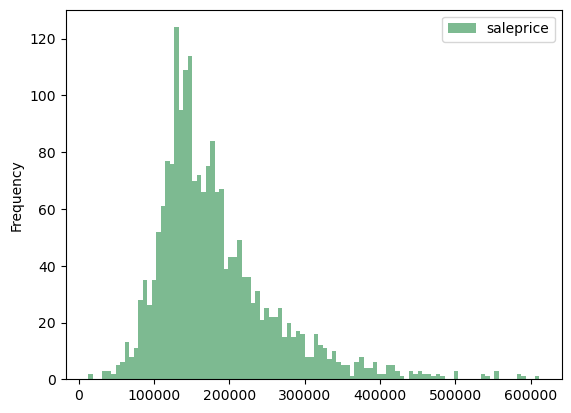

In [314]:
house_train.plot.hist(y='saleprice', bins=100)

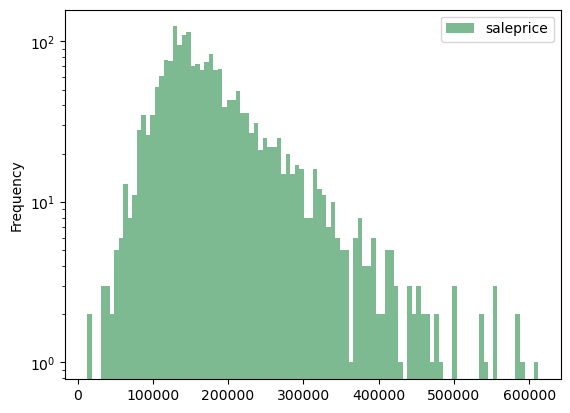

In [315]:
# less skew if we use the log
house_train.plot.hist(y = 'saleprice',log=True, bins=100)

house_train['log_saleprice'] = np.log(house_train.saleprice)

# Look for Correlations within Numerical Categories

In [316]:
# create helper function for plotting

def plot_corr_heatmap(CATEGORY, title):
    COLUMNS = [x for x in CATEGORY]
    COLUMNS.append('log_saleprice')

    fig, ax = plt.subplots(figsize=(12,12))
    corr = house_train[COLUMNS].corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.title(f'{title} Correlations')
    return sns.heatmap(corr, mask=mask, annot=True)

### Discrete

<AxesSubplot:title={'center':'Discrete Correlations'}>

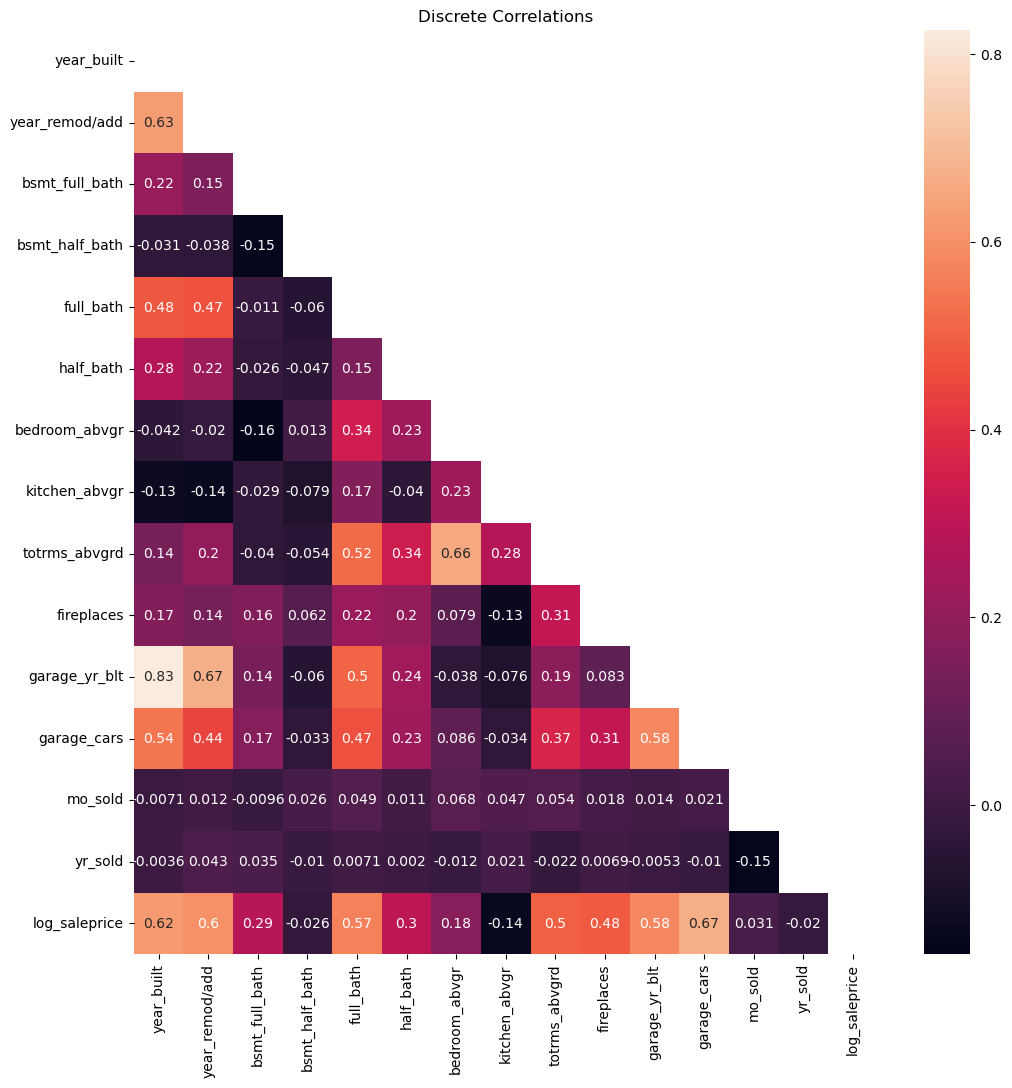

In [317]:
plot_corr_heatmap(DISCRETE, 'Discrete')

### Continous

<AxesSubplot:title={'center':'Continuous Correlations'}>

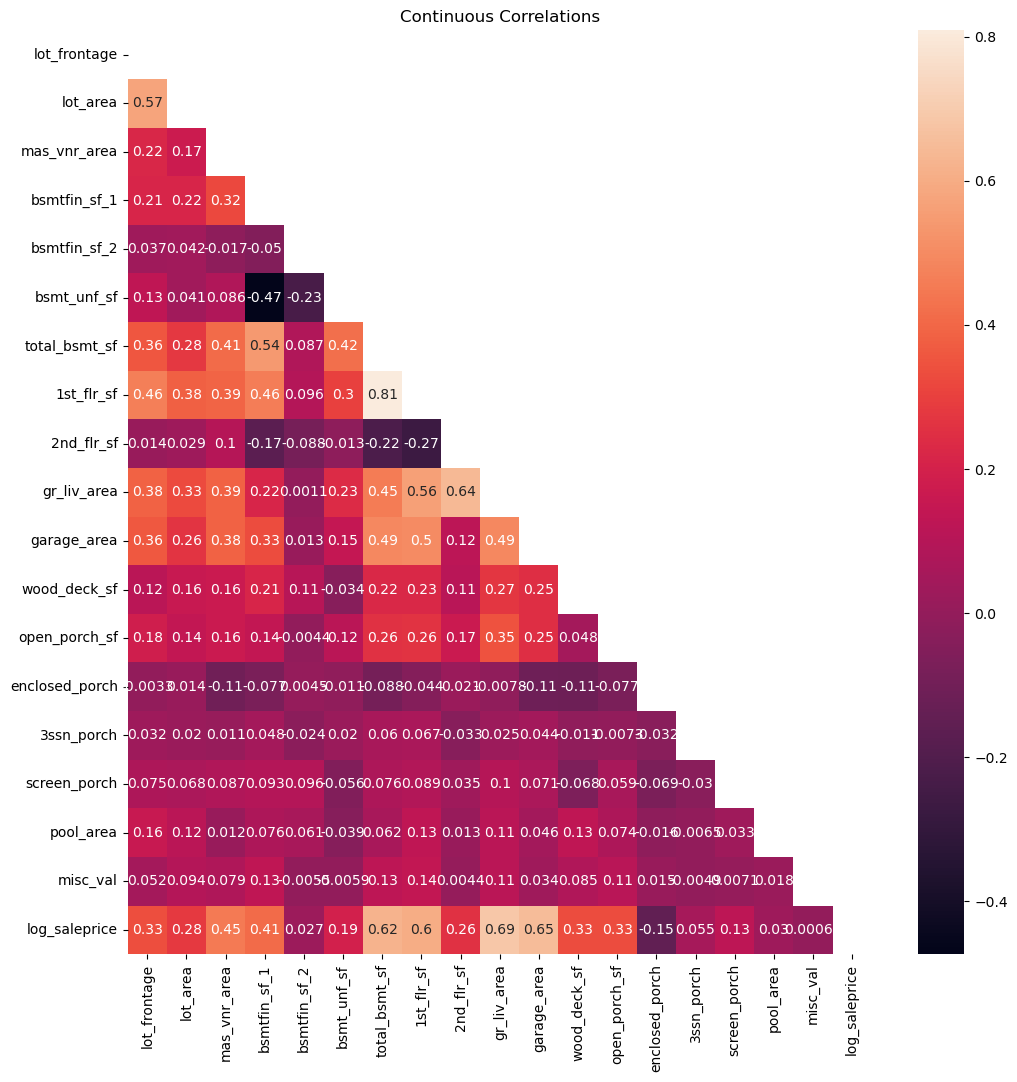

In [318]:
plot_corr_heatmap(CONTINUOUS, 'Continuous')

### Ordinal

Theres clearly a lot of value in these ranked qualitative values, we'll make them numeric and see if we can get some more value. 

       
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

The following columns use this system:  
- exter_qual
- exter_cond
- bsmt_qual
- bsmt_cond
- bsmt_exposure
- heating_qc
- kitchen_qual
- garage_qual
- garage_cond

In [319]:
# function to rank Ordinal quality ratings
def ordinal_to_numeric(val):
    if val == 'Ex':
        return 4
    elif val == 'Gd':
        return 3
    elif val == 'TA':
        return 2
    elif val == 'Fa':
        return 1
    elif val == 'Po':
        return 0
    else:
        pass

Find the columns that use the 'Ex - Po' rating schema

In [320]:
rank_words = ['Ex', 'Gd', 'TA','Fa', 'Po']
rank_words = pd.Series(rank_words)
columns_to_fix = []

# find columns, append to columns to fix
for col in house_train[ORDINAL].columns:
    word_check = rank_words.isin(house_train[ORDINAL][col])
    if word_check.sum() > 0:
        columns_to_fix.append(col)
        
# convert columns to numeric values
for col in columns_to_fix:
    house_train[col] = [ordinal_to_numeric(val) for val in house_train[col]]

Ordinal Correlations

<AxesSubplot:title={'center':'Ordinal Correlations'}>

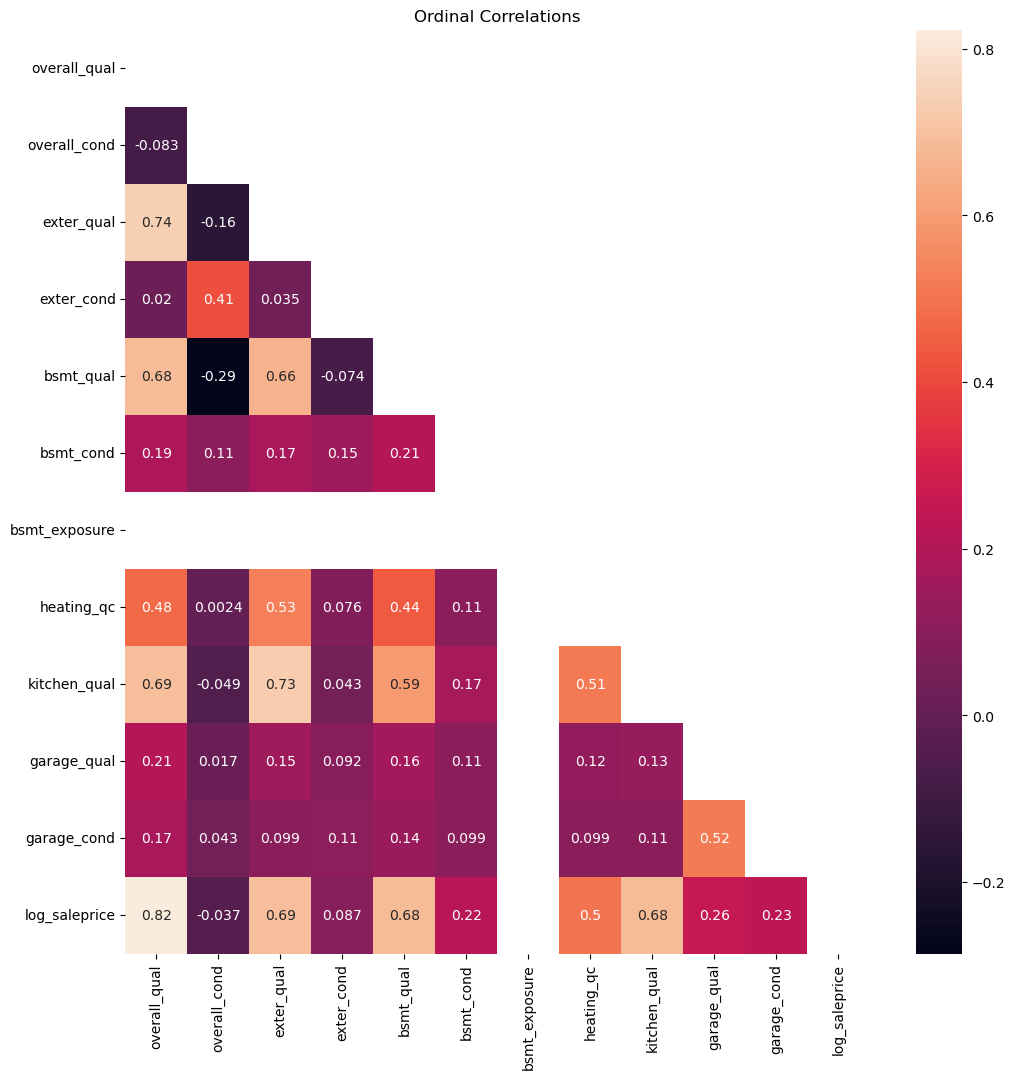

In [321]:
plot_corr_heatmap(ORDINAL, 'Ordinal')

### Nominal

Condition 1 (Nominal): Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition 2 (Nominal): Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

These seem important! location, location, location. Let's make them numerical too. 

In [322]:
# get dummies and concat
house_train = pd.concat([house_train, pd.get_dummies(house_train['condition_1'])], axis=1)

# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['condition_1']).columns.to_list():
    NOMINAL.append(x)

<AxesSubplot:title={'center':'Nominal Correlations'}>

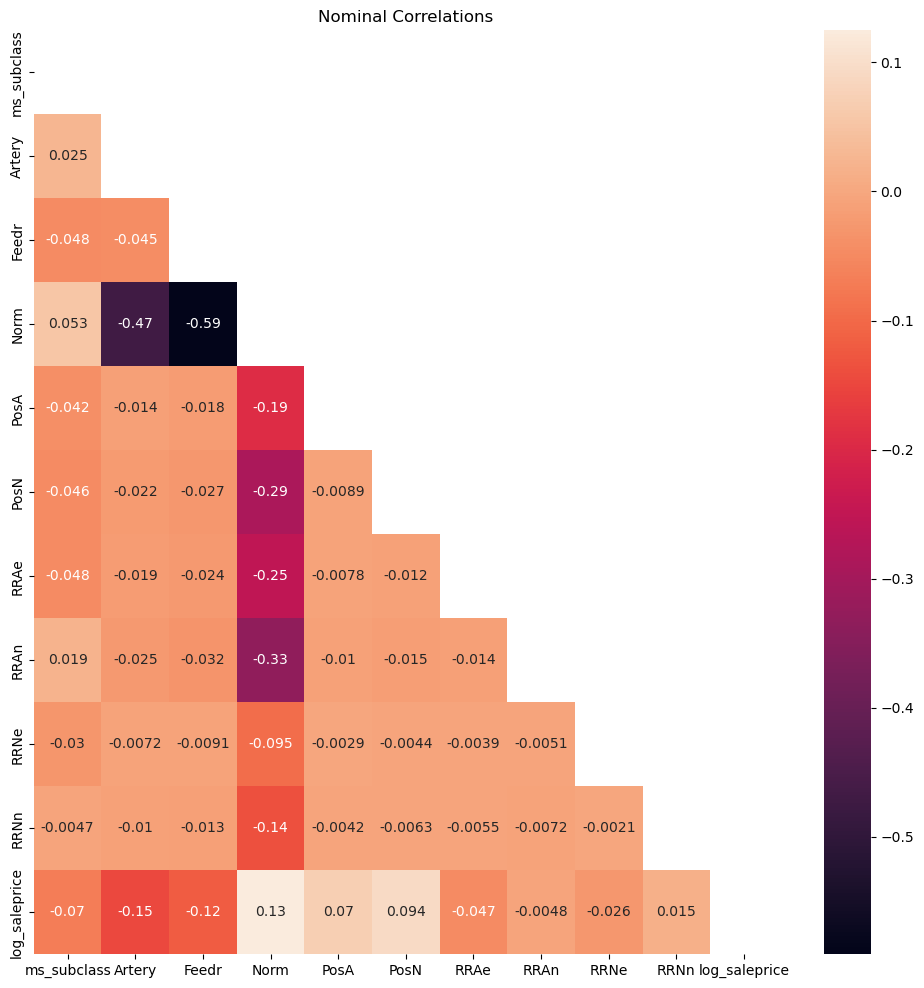

In [323]:
plot_corr_heatmap(NOMINAL, 'Nominal')

'Norm' 'PosA' and 'PosN' have a weak positive correlative effect and being near a railroad or busy thruway has a weak negative correlative effect

# Feature Engineering

In [324]:
# test = house_train.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False)

# neighbor_hood_dict = {}
# for i, val in enumerate(test):
#     neighbor_hood_dict.update({test.index[i]:i})

# house_train['neighborhood_price_rank'] = [neighbor_hood_dict[neighborhood] for neighborhood in house_train.Neighborhood]

KeyError: 'Neighborhood'